In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import statistics as st
from calendar import isleap

In [3]:
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [4]:
def map_plot(ax1):
    ax1.coastlines()
    ax1.set_xticks([70,80,90,100], crs=ccrs.PlateCarree())
    ax1.set_yticks([ 20,25,30,35], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

In [5]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')

# Read Orography
OroData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

t2mD = t2mData.sel(latitude=slice(35,20),longitude=slice(65,100)).t2m
OroD = OroData.sel(latitude=slice(35,20),longitude=slice(65,100))
d2mD = d2mData.sel(latitude=slice(35,20),longitude=slice(65,100)).d2m

# create mask
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values


<xarray.DataArray 'rh' (dayofyear: 63, latitude: 8, longitude: 18)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [55.848347, 47.641235, 38.26484 , ..., 73.598015,       nan,
               nan],
        [58.849285, 57.498535, 44.329952, ..., 74.79277 ,       nan,
               nan],
        [61.69527 , 59.369087, 58.382942, ..., 66.75056 ,       nan,
         75.16347 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [57.13902 , 47.286358, 39.348297, ..., 73.41962 ,       nan,
               nan],
        [58.74514 , 56.288387, 44.715298, ..., 74.44949 ,       nan,
               nan],
        [61.510742, 58.849762, 59.153187, ..., 66.81046 ,       nan,
         74.88031 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [59.045376, 51.647655, 42.651665, ..., 71.02869 ,       nan,
               nan],
        [63.55842 , 63.092487, 46.48728 , ..., 73.93405 ,       nan,
               nan],
        [65.53415 , 63.41782 , 63.385483, ..., 68.068214,       nan,
         73.05948 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 34.0 32.0 30.0 28.0 26.0 24.0 22.0 20.0
  * longitude  (longitude) float32 66.0 68.0 70.0 72.0 ... 94.0 96.0 98.0 100.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

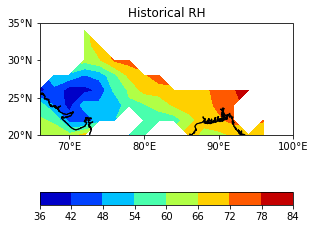

In [9]:


#Calculate rh
rh = (e**((17.625*(d2mD.values-273.15))/(243.04+(d2mD.values-273.15)))/e**((17.625*(t2mD.values-273.15))/(243.04+(t2mD.values-273.15)))*100.0)
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})

rh_ds.attrs
rh_ds.attrs['units']='%'
rh_ds.attrs['long_name']='2m Relative humidity'


# apply mask
rh_ds.rh.values=rh_ds.rh.values*mask

invTS1=rh_ds.rh[((rh_ds.rh.time.dt.month>11) | (rh_ds.rh.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31'))

invERA5HistMean=invTS1.groupby('time.dayofyear').mean()
invERA5HistMean
invERA5HistStd=invTS1.groupby('time.dayofyear').std()
invERA5HistStd

#print(invERA5HistMean)

invTs=invTS1.mean(dim='time')



fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contourf(invTs.longitude.values,invTs.latitude.values,invTs,transform=ccrs.PlateCarree(),cmap ='jet')#,vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
ax1.set_title('Historical RH')
fig.colorbar(m1,orientation='horizontal')

invERA5HistMean

In [12]:
# IPSL
rhData  = xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_hurs_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.hurs.sel(latitude=slice(35,20),longitude=slice(65,100))

# apply mask
rhD.values=rhD.values*mask
rhTsIPSL=(rhD[((rhD.time.dt.month>11) | (rhD.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))

# EC-Earth3
rhData  = xr.open_dataset('../../../Data/CMIP6/EC-Earth3/processed/Regrid_hurs_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.hurs.sel(latitude=slice(35,20),longitude=slice(65,100))

# apply mask
rhD.values=rhD.values*mask
rhTsEC=(rhD[((rhD.time.dt.month>11) | (rhD.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))

# ACCESS-CM2
rhData  = xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/hursNHRegrid_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
rhD  = rhData.hurs.sel(latitude=slice(35,20),longitude=slice(65,100))

# apply mask
rhD.values=rhD.values*mask
rhTsACCESS=(rhD[((rhD.time.dt.month>11) | (rhD.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))

rhTsACCESS


MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MTs
MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
#print(meanMS)

ensTs=rhTsIPSL.copy()
ensTs.values=meanMS

ensTsmean=ensTs.mean(dim='time')

ensTs

<xarray.DataArray 'hurs' (time: 2108, latitude: 8, longitude: 18)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [47.161438, 39.30737 , 25.625334, ..., 73.36872 ,       nan,
               nan],
        [54.9433  , 49.09933 , 26.177313, ..., 67.36028 ,       nan,
               nan],
        [61.5168  , 56.552357, 49.252   , ..., 69.822815,       nan,
         75.19119 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [50.17841 , 48.061665, 32.600742, ..., 60.346996,       nan,
               nan],
        [54.917618, 55.372112, 42.41548 , ..., 56.822956,       nan,
               nan],
        [59.829975, 59.71004 , 59.70798 , ..., 56.879223,       nan,
         57.531433]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [49.516644, 51.204926, 36.60189 , ..., 63.63904 ,       nan,
               nan],
        [54.24835 , 56.204754, 45.15739 , ..., 54.52441 ,       nan,
               nan],
        [59.815216, 61.978115, 63.602673, ..., 53.250423,       nan,
         54.598713]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-01T12:00:00 ... 2014-01-31T12:00:00
  * longitude  (longitude) float32 66.0 68.0 70.0 72.0 ... 94.0 96.0 98.0 100.0
  * latitude   (latitude) float32 34.0 32.0 30.0 28.0 26.0 24.0 22.0 20.0
    height     float64 ...
Attributes:
    standard_name:       relative_humidity
    long_name:           Near-Surface Relative Humidity
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 d
    description:         This is the relative humidity with respect to liquid...
    history:             none
    cell_measures:       area: areacella

In [13]:
ensTsMean=ensTs.groupby('time.dayofyear').mean()
ensTsStd=ensTs.groupby('time.dayofyear').std()
ensTsMean

<xarray.DataArray 'hurs' (dayofyear: 63, latitude: 8, longitude: 18)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [46.90911 , 42.44671 , 29.64406 , ..., 68.522644,       nan,
               nan],
        [54.167244, 50.04372 , 37.436268, ..., 60.58077 ,       nan,
               nan],
        [58.837692, 56.033775, 52.52109 , ..., 60.137558,       nan,
         62.823395]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [46.556686, 43.354523, 30.669678, ..., 66.80389 ,       nan,
               nan],
        [54.009132, 51.00128 , 37.88799 , ..., 59.537323,       nan,
               nan],
        [59.139618, 56.489227, 52.051296, ..., 59.46137 ,       nan,
         62.48849 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [45.087994, 42.74332 , 30.502266, ..., 69.79289 ,       nan,
               nan],
        [53.366653, 50.10018 , 37.05864 , ..., 62.043438,       nan,
               nan],
        [58.594925, 55.358955, 51.703445, ..., 61.964363,       nan,
         61.792343]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 66.0 68.0 70.0 72.0 ... 94.0 96.0 98.0 100.0
  * latitude   (latitude) float32 34.0 32.0 30.0 28.0 26.0 24.0 22.0 20.0
    height     float64 2.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

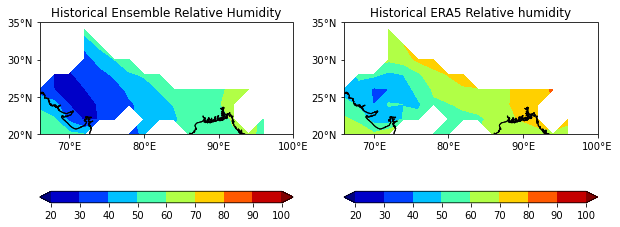

In [21]:
levels = np.linspace(20,100, 9)

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contourf(ensTsmean.longitude.values,ensTsmean.latitude.values,ensTsmean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax1)
ax1.coastlines()
ax1.set_title('Historical Ensemble Relative Humidity')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())

m2=ax2.contourf(invTs.longitude.values,invTs.latitude.values,invTs,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax2)
ax2.coastlines()
ax2.set_title('Historical ERA5 Relative humidity')
fig.colorbar(m2,orientation='horizontal')



In [18]:
#### BC historical

ensFu=ensTs.copy()


### Change factor

BC=[]


for d in ensFu.time:
    t=pd.Period(d.values, freq='H').dayofyear
    yr=d.dt.year.values
    if(isleap(yr) & t>334 ):
        t=t-1
    
    BC.append(invERA5HistMean.sel(dayofyear=t).values+
                               (invERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    

#ensFuBC=np.array(BC)

ensFuBC = xr.DataArray( data=BC,dims=[ 'time','latitude','longitude'], 
                       coords=dict(time=ensFu.time,latitude=ensFu.latitude,longitude=ensFu.longitude))

ensFuBC

ensFuBCMean=ensFuBC.mean(dim='time')


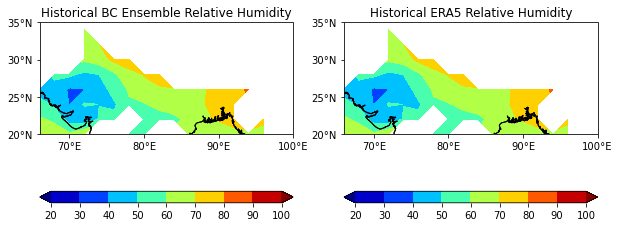

In [20]:
levels = np.linspace(20, 100, 9)

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contourf(ensFuBCMean.longitude.values,ensFuBCMean.latitude.values,ensFuBCMean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax1)
ax1.coastlines()
ax1.set_title('Historical BC Ensemble Relative Humidity')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())

m2=ax2.contourf(invTs.longitude.values,invTs.latitude.values,invTs,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax2)
ax2.coastlines()
ax2.set_title('Historical ERA5 Relative Humidity')
fig.colorbar(m2,orientation='horizontal')

In [22]:
# SSP 370
sp='370'
folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    # IPSL
rhData = xr.open_dataset(folderString+'Regrid_hurs_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
rhD = rhData.hurs.sel(latitude=slice(35,20),longitude=slice(65,100))
# apply mask
rhD.values=rhD.values*mask
rhTsIPSL=rhD[((rhD.time.dt.month>11) | (rhD.time.dt.month<2)) ]

# EC-Earth3
folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
rhData = xr.open_dataset(folderString+'Regrid_hurs_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
rhD = rhData.hurs.sel(latitude=slice(35,20),longitude=slice(65,100))
# apply mask
rhD.values=rhD.values*mask
rhTsEC=rhD[((rhD.time.dt.month>11) | (rhD.time.dt.month<2)) ]


# ACCESS-CM2

folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
rhData = xr.open_dataset(folderString+'Regrid_hurs_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
rhD = rhData.hurs.sel(latitude=slice(35,20),longitude=slice(65,100))
# apply mask
rhD.values=rhD.values*mask
rhTsACCESS=rhD[((rhD.time.dt.month>11) | (rhD.time.dt.month<2)) ]


rhTsACCESS


MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MTs
MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
#print(meanMS)

ensTsSSP370=rhTsIPSL.copy()
ensTsSSP370.values=meanMS

ensTsSSP370


<xarray.DataArray 'hurs' (time: 5332, latitude: 8, longitude: 18)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [56.907604, 50.892136, 34.681267, ..., 63.36878 ,       nan,
               nan],
        [61.412502, 56.453396, 41.83514 , ..., 56.665936,       nan,
               nan],
        [64.04989 , 60.021698, 58.78996 , ..., 58.327297,       nan,
         60.995007]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [43.896786, 33.79976 , 21.832321, ..., 73.053276,       nan,
               nan],
        [58.186596, 53.923786, 32.974   , ..., 61.009186,       nan,
               nan],
        [66.26165 , 61.483032, 56.728027, ..., 61.592926,       nan,
         59.987324]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [45.799175, 33.99361 , 21.801971, ..., 70.89234 ,       nan,
               nan],
        [60.58247 , 54.50613 , 32.66797 , ..., 62.203663,       nan,
               nan],
        [66.60061 , 60.57452 , 55.363895, ..., 61.23378 ,       nan,
         56.693287]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
  * longitude  (longitude) float32 66.0 68.0 70.0 72.0 ... 94.0 96.0 98.0 100.0
  * latitude   (latitude) float32 34.0 32.0 30.0 28.0 26.0 24.0 22.0 20.0
    height     float64 ...
Attributes:
    standard_name:       relative_humidity
    long_name:           Near-Surface Relative Humidity
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 d
    description:         This is the relative humidity with respect to liquid...
    history:             none
    cell_measures:       area: areacella

In [23]:
# SSP 585
sp='585'

folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    # IPSL
rhData = xr.open_dataset(folderString+'Regrid_hurs_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
rhD = rhData.hurs.sel(latitude=slice(35,20),longitude=slice(65,100))
# apply mask
rhD.values=rhD.values*mask
rhTsIPSL=rhD[((rhD.time.dt.month>11) | (rhD.time.dt.month<2)) ]

# EC-Earth3
folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
rhData = xr.open_dataset(folderString+'Regrid_hurs_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
rhD = rhData.hurs.sel(latitude=slice(35,20),longitude=slice(65,100))
# apply mask
rhD.values=rhD.values*mask
rhTsEC=rhD[((rhD.time.dt.month>11) | (rhD.time.dt.month<2)) ]


# ACCESS-CM2

folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
rhData = xr.open_dataset(folderString+'Regrid_hurs_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
rhD = rhData.hurs.sel(latitude=slice(35,20),longitude=slice(65,100))
# apply mask
rhD.values=rhD.values*mask
rhTsACCESS=rhD[((rhD.time.dt.month>11) | (rhD.time.dt.month<2)) ]


rhTsACCESS


MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MTs
MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
#print(meanMS)

ensTsSSP585=rhTsIPSL.copy()
ensTsSSP585.values=meanMS

ensTsSSP585


<xarray.DataArray 'hurs' (time: 5332, latitude: 8, longitude: 18)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [56.90552 , 50.903152, 34.868618, ..., 63.67018 ,       nan,
               nan],
        [61.421326, 56.395477, 41.770565, ..., 56.39249 ,       nan,
               nan],
        [64.06952 , 60.035248, 58.774075, ..., 58.444805,       nan,
         61.06825 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [48.52185 , 44.21877 , 35.16003 , ..., 65.33965 ,       nan,
               nan],
        [57.046375, 54.146885, 39.67349 , ..., 57.205273,       nan,
               nan],
        [61.810406, 60.75765 , 55.78565 , ..., 45.64778 ,       nan,
         52.25604 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [48.570698, 42.56178 , 33.73821 , ..., 64.367134,       nan,
               nan],
        [58.00469 , 54.290207, 41.17823 , ..., 55.326077,       nan,
               nan],
        [63.658047, 61.07488 , 58.464603, ..., 47.517048,       nan,
         52.466568]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
  * longitude  (longitude) float32 66.0 68.0 70.0 72.0 ... 94.0 96.0 98.0 100.0
  * latitude   (latitude) float32 34.0 32.0 30.0 28.0 26.0 24.0 22.0 20.0
    height     float64 ...
Attributes:
    standard_name:       relative_humidity
    long_name:           Near-Surface Relative Humidity
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 d
    description:         This is the relative humidity with respect to liquid...
    history:             none
    cell_measures:       area: areacella

In [24]:
#### BC historical

ensFuSSP370=ensTsSSP370.copy()


### Change factor

BC=[]


for d in ensFuSSP370.time:
    t=pd.Period(d.values, freq='H').dayofyear
    yr=d.dt.year.values
    if(isleap(yr) & t>334 ):
        t=t-1
    
    BC.append(invERA5HistMean.sel(dayofyear=t).values+
                               (invERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFuSSP370.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    

#ensFuBC=np.array(BC)

ensFuBCSSP370 = xr.DataArray( data=BC,dims=[ 'time','latitude','longitude'], 
                       coords=dict(time=ensFuSSP370.time,latitude=ensFuSSP370.latitude,longitude=ensFuSSP370.longitude))

ensFuBCSSP370

#ensFuBCSSP370Mean=ensFuBCSSP370.mean(dim='time')


<xarray.DataArray (time: 5332, latitude: 8, longitude: 18)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [75.42902 , 64.36985 , 47.047318, ..., 69.14713 ,       nan,
               nan],
        [74.083466, 72.122345, 51.999226, ..., 72.26436 ,       nan,
               nan],
        [74.616135, 68.441376, 71.87071 , ..., 64.98327 ,       nan,
         73.64567 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [50.13236 , 29.268833, 27.827694, ..., 79.7017  ,       nan,
               nan],
        [67.40637 , 63.57446 , 40.829952, ..., 75.765816,       nan,
               nan],
        [75.85154 , 69.382065, 68.499626, ..., 69.229454,       nan,
         73.29989 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [55.756298, 25.713766, 24.851227, ..., 77.48102 ,       nan,
               nan],
        [71.82886 , 62.89217 , 35.76702 , ..., 76.91663 ,       nan,
               nan],
        [78.93455 , 66.927185, 65.67951 , ..., 68.96677 ,       nan,
         68.67843 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
  * latitude   (latitude) float32 34.0 32.0 30.0 28.0 26.0 24.0 22.0 20.0
  * longitude  (longitude) float32 66.0 68.0 70.0 72.0 ... 94.0 96.0 98.0 100.0

In [25]:
#### BC historical

ensFuSSP585=ensTsSSP585.copy()


### Change factor

BC=[]


for d in ensFuSSP585.time:
    t=pd.Period(d.values, freq='H').dayofyear
    yr=d.dt.year.values
    if(isleap(yr) & t>334 ):
        t=t-1
    
    BC.append(invERA5HistMean.sel(dayofyear=t).values+
                               (invERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFuSSP585.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    

#ensFuBC=np.array(BC)

ensFuBCSSP585 = xr.DataArray( data=BC,dims=[ 'time','latitude','longitude'], 
                       coords=dict(time=ensFuSSP585.time,latitude=ensFuSSP585.latitude,longitude=ensFuSSP585.longitude))

ensFuBCSSP585

#ensFuBCSSP585Mean=ensFuBCSSP585.mean(dim='time')


<xarray.DataArray (time: 5332, latitude: 8, longitude: 18)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [75.42495 , 64.39168 , 47.373966, ..., 69.407425,       nan,
               nan],
        [74.10202 , 71.990204, 51.886642, ..., 72.08775 ,       nan,
               nan],
        [74.6648  , 68.472206, 71.83653 , ..., 65.097984,       nan,
         73.70647 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [58.7785  , 47.33081 , 46.475838, ..., 71.59482 ,       nan,
               nan],
        [65.21818 , 63.96399 , 52.193027, ..., 73.03428 ,       nan,
               nan],
        [67.11021 , 68.12066 , 67.16936 , ..., 52.479324,       nan,
         65.101944]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [60.815285, 45.45945 , 44.36478 , ..., 70.998985,       nan,
               nan],
        [66.69798 , 62.48533 , 50.355503, ..., 70.552864,       nan,
               nan],
        [72.06272 , 67.91649 , 71.78838 , ..., 52.27908 ,       nan,
         64.1551  ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
  * latitude   (latitude) float32 34.0 32.0 30.0 28.0 26.0 24.0 22.0 20.0
  * longitude  (longitude) float32 66.0 68.0 70.0 72.0 ... 94.0 96.0 98.0 100.0

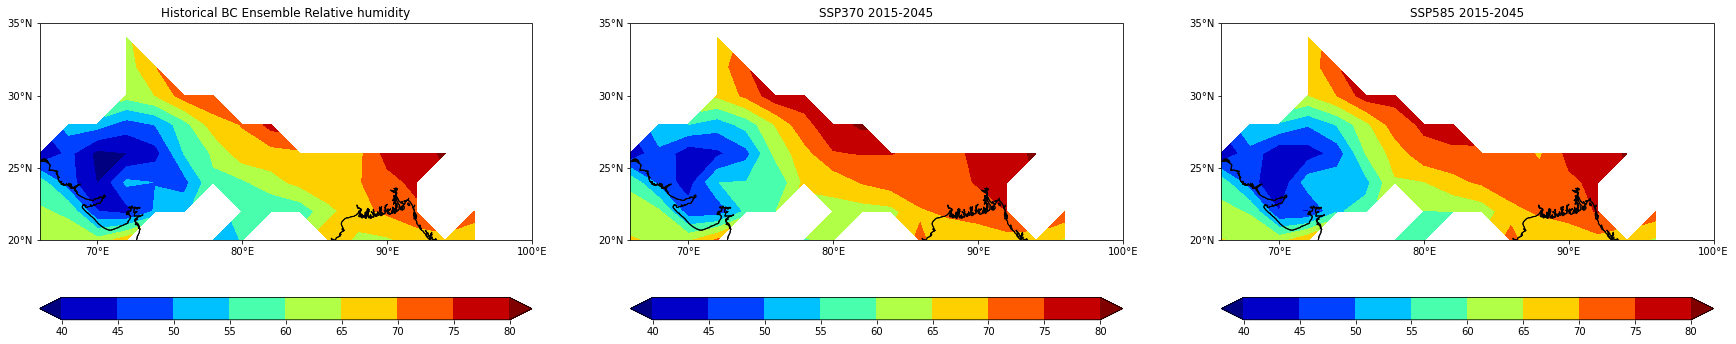

In [39]:
ensSSP585Mean=ensFuBCSSP585.sel(time=slice('2015-1-1','2045-12-31')).mean(dim='time')
ensSSP370Mean=ensFuBCSSP370.sel(time=slice('2015-1-1','2045-12-31')).mean(dim='time')

levels = np.linspace(40, 80, 9)

fig = plt.figure(figsize=(30,7))
ax1 = fig.add_subplot(131,projection=ccrs.PlateCarree())

m1=ax1.contourf(ensFuBCMean.longitude.values,ensFuBCMean.latitude.values,ensFuBCMean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax1)
ax1.coastlines()
ax1.set_title('Historical BC Ensemble Relative humidity')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(132,projection=ccrs.PlateCarree())

m2=ax2.contourf(ensSSP370Mean.longitude.values,ensSSP370Mean.latitude.values,ensSSP370Mean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax2)
ax2.coastlines()
ax2.set_title('SSP370 2015-2045')
fig.colorbar(m2,orientation='horizontal')

ax3 = fig.add_subplot(133,projection=ccrs.PlateCarree())

m3=ax3.contourf(ensSSP585Mean.longitude.values,ensSSP585Mean.latitude.values,ensSSP585Mean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax3)
ax3.coastlines()
ax3.set_title('SSP585 2015-2045')
fig.colorbar(m3,orientation='horizontal')

plt.savefig('Spatial_Relative_humidity_2015_2045.eps')

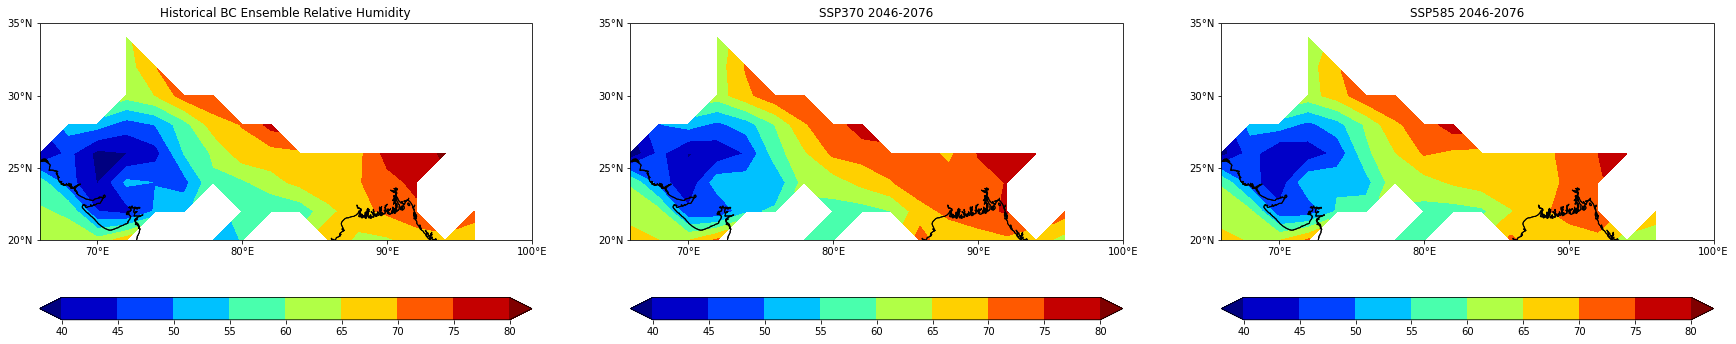

In [30]:
ensSSP585Mean=ensFuBCSSP585.sel(time=slice('2046-1-1','2076-12-31')).mean(dim='time')
ensSSP370Mean=ensFuBCSSP370.sel(time=slice('2046-1-1','2076-12-31')).mean(dim='time')

levels = np.linspace(40, 80, 9)

fig = plt.figure(figsize=(30,7))
ax1 = fig.add_subplot(131,projection=ccrs.PlateCarree())

m1=ax1.contourf(ensFuBCMean.longitude.values,ensFuBCMean.latitude.values,ensFuBCMean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax1)
ax1.coastlines()
ax1.set_title('Historical BC Ensemble Relative Humidity')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(132,projection=ccrs.PlateCarree())

m2=ax2.contourf(ensSSP370Mean.longitude.values,ensSSP370Mean.latitude.values,ensSSP370Mean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax2)
ax2.coastlines()
ax2.set_title('SSP370 2046-2076')
fig.colorbar(m2,orientation='horizontal')

ax3 = fig.add_subplot(133,projection=ccrs.PlateCarree())

m3=ax3.contourf(ensSSP585Mean.longitude.values,ensSSP585Mean.latitude.values,ensSSP585Mean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax3)
ax3.coastlines()
ax3.set_title('SSP585 2046-2076')
fig.colorbar(m3,orientation='horizontal')
plt.savefig('Spatial_Relative_Humidity_2046_2076.eps')

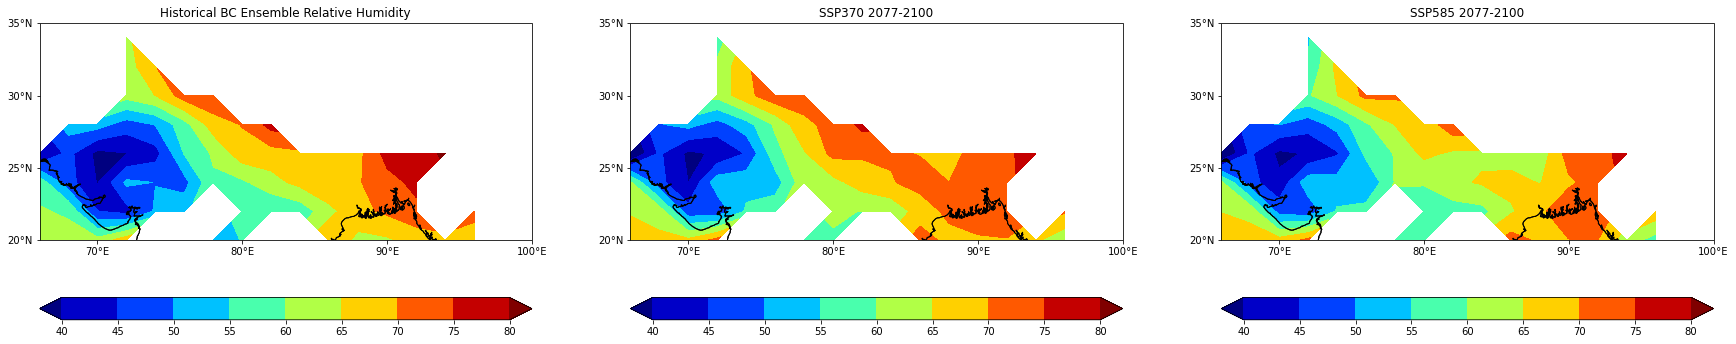

In [40]:
ensSSP585Mean=ensFuBCSSP585.sel(time=slice('2077-1-1','2100-12-31')).mean(dim='time')
ensSSP370Mean=ensFuBCSSP370.sel(time=slice('2077-1-1','2100-12-31')).mean(dim='time')

levels = np.linspace(40,80, 9)

fig = plt.figure(figsize=(30,7))
ax1 = fig.add_subplot(131,projection=ccrs.PlateCarree())

m1=ax1.contourf(ensFuBCMean.longitude.values,ensFuBCMean.latitude.values,ensFuBCMean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax1)
ax1.coastlines()
ax1.set_title('Historical BC Ensemble Relative Humidity')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(132,projection=ccrs.PlateCarree())

m2=ax2.contourf(ensSSP370Mean.longitude.values,ensSSP370Mean.latitude.values,ensSSP370Mean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax2)
ax2.coastlines()
ax2.set_title('SSP370 2077-2100')
fig.colorbar(m2,orientation='horizontal')

ax3 = fig.add_subplot(133,projection=ccrs.PlateCarree())

m3=ax3.contourf(ensSSP585Mean.longitude.values,ensSSP585Mean.latitude.values,ensSSP585Mean,
                transform=ccrs.PlateCarree(),cmap ='jet',levels=levels,extend='both')

map_plot(ax3)
ax3.coastlines()
ax3.set_title('SSP585 2077-2100')
fig.colorbar(m3,orientation='horizontal')
plt.savefig('Spatial_Relative_Humidity_2077_2100.eps')